# Necessary Imports

In [4]:
!pip install tensorflow tensorflow_addons tensorflow_datasets tensorflow_addons tensorflow_gan

!pip install keras-tuner


  Using cached tensorflow-2.12.0-cp38-cp38-win_amd64.whl (1.9 kB)
     ---------------------------------------- 5.4/5.4 MB 3.4 MB/s eta 0:00:00
  Using cached tensorflow_intel-2.12.0-cp38-cp38-win_amd64.whl (272.8 MB)
  Using cached jax-0.4.8-py3-none-any.whl
     --------------------------------------- 14.7/14.7 MB 15.6 MB/s eta 0:00:00
  Using cached protobuf-4.22.3-cp38-cp38-win_amd64.whl (420 kB)
  Using cached tensorboard-2.12.2-py3-none-any.whl (5.6 MB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
     ---------------------------------------- 3.0/3.0 MB 15.9 MB/s eta 0:00:00
     ---------------------------------------- 120.6/120.6 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 223.6/223.6 kB 6.9 MB/s eta 0:00:00
  Using cached ml_dtypes-0.1.0-cp38-cp38-win_amd64.whl (120 kB)
     ---------------------------------------- 4.1/4.1 MB 16.4 MB/s eta 0:00:00

ERROR: Could not install packages due to an OSError: [WinError 5] Acesso negado: 'C:\\Users\\Pichau\\anaconda3\\Lib\\site-packages\\google\\protobuf\\~-ternal\\_api_implementation.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [3]:
# Import built-in Python modules
import os, random, json, PIL, shutil, re, glob, zipfile


# Import third-party modules

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
from PIL import Image
from tensorflow import keras
from tensorflow_addons import layers as tfa_layers
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, PReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.utils import make_grid, save_image

# Import third-party submodules
from kaggle_datasets import KaggleDatasets
from scipy.linalg import sqrtm


ModuleNotFoundError: No module named 'tensorflow_datasets'

# Abstract

    In the domain of computer-generated artwork, Generative Adversarial Networks (GANs) have made remarkable advancements in recent years. As GANs comprise two neural networks, a generator and a discriminator, they work in tandem to produce realistic and visually appealing images. This study investigates the development and implementation of a GAN capable of generating between 7,000 and 10,000 Monet-style images. We present an in-depth analysis of the architecture, training process, and evaluation metrics employed to create a GAN that achieves this artistic goal.

# Introduction
       Generative Adversarial Networks (GANs) have emerged as a powerful tool for generating realistic images by learning the underlying data distribution (Goodfellow et al., 2014). By pitting a generator network against a discriminator network, GANs have demonstrated the ability to produce high-quality results in various applications, including image synthesis, style transfer, and image inpainting (Karras et al., 2018; Zhu et al., 2017; Yu et al., 2018). In this work, we focus on the generation of Monet-style images, which presents a unique challenge due to the intricate, impressionistic nature of the art.
       
   ## 1. Evolution and Advancements in Generative Adversarial Networks

            Since the inception of GANs by Goodfellow et al. (2014), the field has experienced significant growth and innovation, resulting in numerous architectural and training advancements. In this section, we outline the key developments that have contributed to the success of GANs and informed our choice of architecture for generating Monet-style images.

  #### 1.1. Deep Convolutional GAN (DCGAN)

            Radford et al. (2015) introduced the DCGAN, a GAN variant that leverages deep convolutional layers in both generator and discriminator networks. DCGAN also employs batch normalization and architectural modifications, such as eliminating fully connected layers, which improve training stability and convergence. DCGAN has served as a foundational model for subsequent GAN architectures.

  #### 1.2. Wasserstein GAN (WGAN)

            Arjovsky et al. (2017) proposed the WGAN to address issues related to training instability and mode collapse. By modifying the GAN's objective function to use the Wasserstein-1 distance, the WGAN provides a more meaningful and stable training process. This innovation has resulted in more robust GANs capable of generating higher-quality images.

  #### 1.3. Progressive Growing of GANs (PGGAN)

            Karras et al. (2017) introduced the concept of progressive growing in GANs to generate high-resolution images more efficiently. PGGAN progressively increases the resolution of both generator and discriminator networks by gradually adding layers during training. This approach reduces training time and improves the quality of generated images, making it a valuable addition to our Monet-style image generation model.
            
  #### 1.4. Cycle Generative Adversarial Networks (CycleGAN)

            Zhu et al. (2017) introduced CycleGAN, an unsupervised image-to-image translation model that allows for transferring styles between different image domains without requiring paired data. CycleGAN consists of two generators and two discriminators, with an additional cycle consistency loss that ensures the translation between image domains is consistent. This innovation has enabled the generation of artistic images and style transfer without the need for an extensive dataset of paired examples, making it a valuable reference for our Monet-style image generation model.            

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
gpus
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [1]:
# detect and init the TPU
import os
def get_strategy():
    """
    This function get_strategy() is used to get the appropriate distribution strategy for training a deep learning model in TensorFlow.

    It first tries to find if there is any TPU available and if so, initializes the TPU and creates a TPUStrategy object for distributing the computation on multiple TPU cores. If TPU is not found, it then checks if there is any GPU available and creates a OneDeviceStrategy object for using a single GPU device. If both TPU and GPU are not found, it creates a OneDeviceStrategy object for using the CPU.

    Args:
    None.

    Returns:
    A distribution strategy object (TPUStrategy or OneDeviceStrategy), depending on the available hardware.
    """
    
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    elif tf.config.list_physical_devices('GPU'):
        print('Running on GPU')
        strategy = tf.distribute.OneDeviceStrategy("GPU:0")
    else:
        print('Running on CPU')
        strategy = tf.distribute.OneDeviceStrategy("CPU:0")

    return strategy

tpu_strategy = get_strategy()


NameError: name 'tf' is not defined

In [4]:
monetFiles = glob.glob('monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(monetFiles))
photoFiles = glob.glob('photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(photoFiles))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [5]:
monetFiles

['monet_tfrec\\monet00-60.tfrec',
 'monet_tfrec\\monet04-60.tfrec',
 'monet_tfrec\\monet08-60.tfrec',
 'monet_tfrec\\monet12-60.tfrec',
 'monet_tfrec\\monet16-60.tfrec']

In [6]:
def data_augment(image):
    """
    Perform simple data augmentation on the input image.

    The function applies random horizontal flip, random hue adjustment,
    random saturation adjustment, and random contrast adjustment to the input image.

    Args:
        image (tf.Tensor): A 3D tensor representing the input image with shape (height, width, channels).

    Returns:
        tf.Tensor: A 3D tensor representing the augmented image with the same shape as the input image.
    """
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    
    
    return image

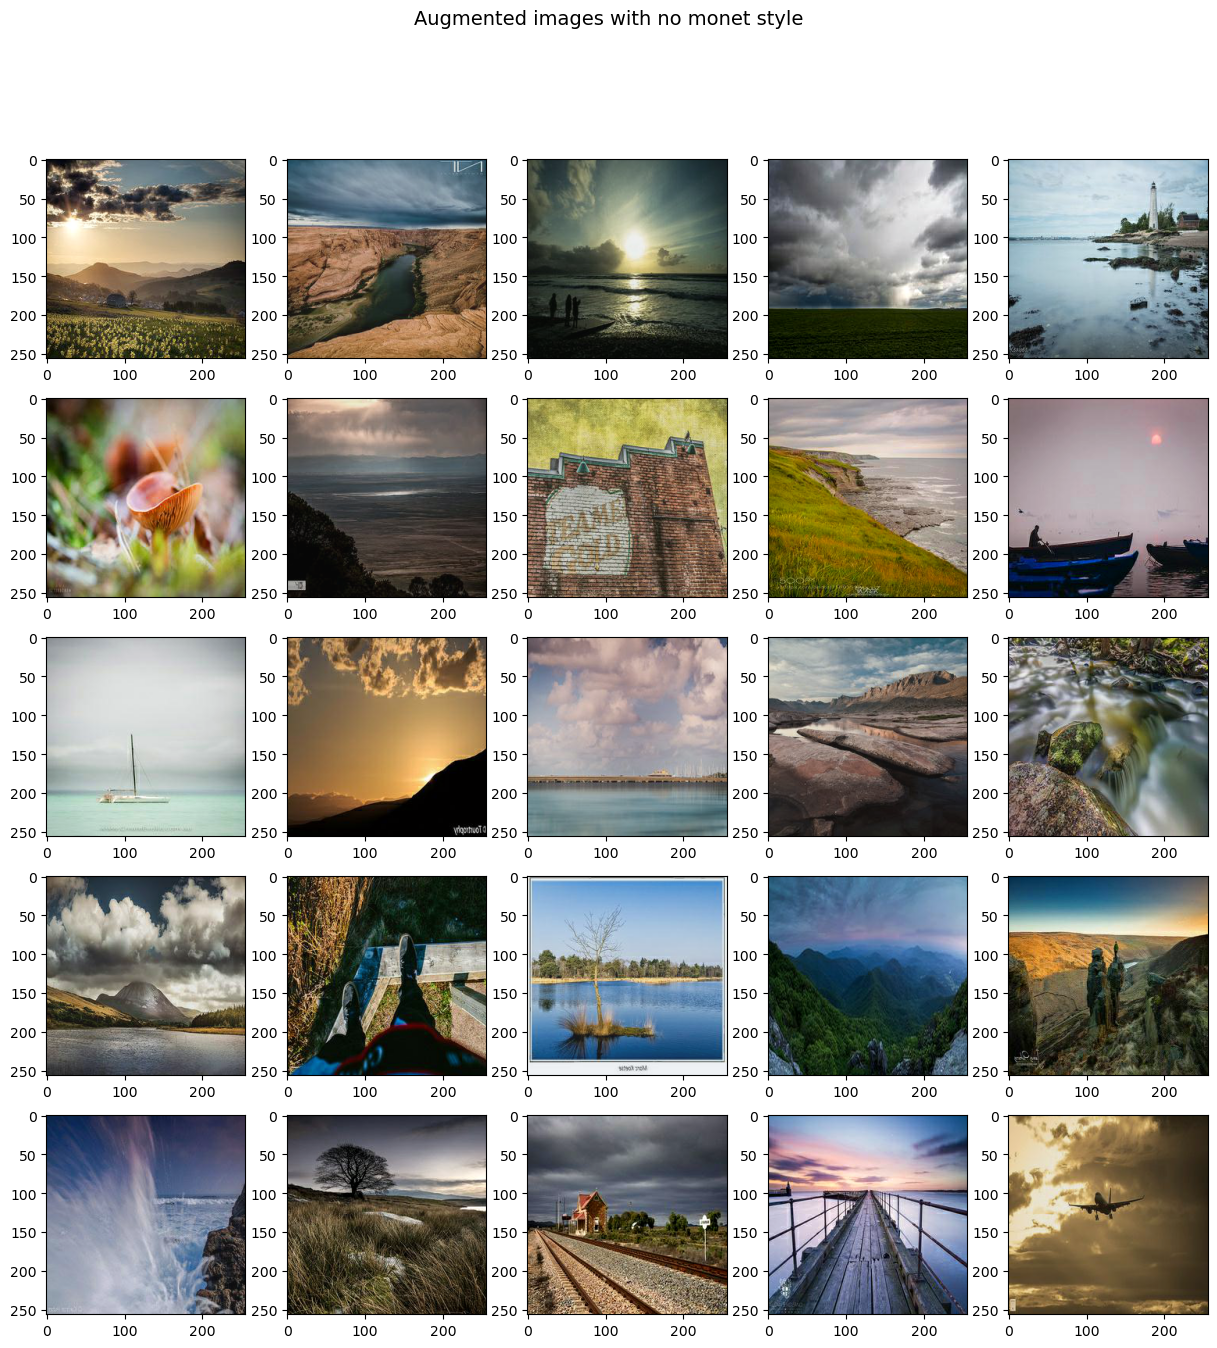

In [7]:
_, ax = plt.subplots(5,5, figsize=(15,15))
plt.suptitle('Augmented images with no monet style', fontsize=14)

ind = 0 
for k in range(5):
    for kk in range(5):
        ax[k][kk].imshow(data_augment(np.array(Image.open('photo_jpg/'+os.listdir('photo_jpg')[ind]))))
        ind += 1
        
plt.show()

# Data preprocessing and loading

 - decode_image function
 
        This function decodes a JPEG-encoded image, normalizes its pixel values to the range of [-1, 1], and reshapes it. The input is a tensor containing a JPEG-encoded image, and the output is a 3D tensor representing the decoded, normalized, and reshaped image with shape (height, width, channels).

 - read_tfrecord function
 
        The purpose of this function is to read and parse a single example from a TFRecord dataset. It takes as input a tensor containing a single serialized example from a TFRecord dataset and returns a 3D tensor representing the decoded and preprocessed image contained in the example. This function relies on the decode_image(image) function for image preprocessing.

 - load_dataset function
 
        This function loads a dataset from a list of TFRecord files. It takes a list of file paths to the TFRecord files as input and returns a dataset containing the images from the provided TFRecord files. The function utilizes the read_tfrecord(example) function to parse and preprocess the images.

 - get_gan_dataset function
 
        The primary purpose of this function is to create a GAN dataset by loading, augmenting, batching, and prefetching Monet and photo datasets. It takes as input a list of file paths to the Monet TFRecord files, a list of file paths to the photo TFRecord files, and an optional batch size (default is 1).

In [8]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    """
    Decode a JPEG-encoded image, normalize its pixel values, and reshape it.

    Args:
        image (tf.Tensor): A tensor containing a JPEG-encoded image.

    Returns:
        tf.Tensor: A 3D tensor representing the decoded, normalized, and reshaped image with shape (height, width, channels).
    """
    
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    """
    Read and parse a single example from a TFRecord dataset.

    Args:
        example (tf.Tensor): A tensor containing a single serialized example from a TFRecord dataset.

    Returns:
        tf.Tensor: A 3D tensor representing the decoded and preprocessed image contained in the example.
    """
    
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    """
    Load a dataset from a list of TFRecord files.

    Args:
        filenames (list): A list of file paths to the TFRecord files.

    Returns:
        tf.data.Dataset: A dataset containing the images from the provided TFRecord files.
    """
    
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_gan_dataset(monet_files, photo_files, batch_size=1):
    """
    Create a GAN dataset by loading, augmenting, batching, and prefetching Monet and photo datasets.

    Args:
        monet_files (list): A list of file paths to the Monet TFRecord files.
        photo_files (list): A list of file paths to the photo TFRecord files.
        batch_size (int, optional): The batch size for the datasets. Default is 1.

    Returns:
        tuple: A tuple containing three datasets:
               1. gan_ds (tf.data.Dataset): A zipped dataset containing tuples of (Monet images, photo images) batches.
               2. photo_ds (tf.data.Dataset): A dataset containing the augmented and batched photo images.
               3. monet_ds (tf.data.Dataset): A dataset containing the augmented and batched Monet images.
    """

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    monet_ds = monet_ds.map(data_augment, num_parallel_calls=AUTOTUNE)
    photo_ds = photo_ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        
    monet_ds = monet_ds.batch(batch_size)
    photo_ds = photo_ds.batch(batch_size)
    
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds, photo_ds, monet_ds

In [9]:
final_dataset, photo_ds, monet_ds = get_gan_dataset(monetFiles, photoFiles, batch_size=1)

# Utility Methods

In [10]:

import tensorflow as tf
from tensorflow.keras import layers


class ResNetBlock(tf.keras.Model):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResNetBlock, self).__init__()
        self.conv1 = layers.Conv2D(
            filters=out_channels,
            kernel_size=kernel_size,
            strides=1,
            padding="same",
            use_bias=False,
        )
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(
            filters=out_channels,
            kernel_size=kernel_size,
            strides=1,
            padding="same",
            use_bias=False,
        )
        self.bn2 = layers.BatchNormalization()

    def call(self, inputs):
        residual = inputs
        out = self.conv1(inputs)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out



def downsample(filters, size, apply_instancenorm=True, strides=2):
    """
    Create a downsampling block for a neural network with Conv2D, InstanceNormalization, and LeakyReLU layers.

    Args:
        filters (int): The number of filters in the Conv2D layer.
        size (int): The kernel size for the Conv2D layer.
        apply_instancenorm (bool, optional): Whether to include InstanceNormalization layer. Default is True.
        strides (int, optional): The stride size for the Conv2D layer. Default is 2.

    Returns:
        tf.keras.Sequential: A Keras Sequential model containing the downsampling block layers.
    """
    
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, 
                             size, 
                             strides=strides, 
                             padding='same',
                             kernel_initializer=initializer, 
                             use_bias=False))
    
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
        
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    """
    Create an upsampling block for a neural network with Conv2DTranspose, InstanceNormalization, and ReLU layers.

    Args:
        filters (int): The number of filters in the Conv2DTranspose layer.
        size (int): The kernel size for the Conv2DTranspose layer.
        apply_dropout (bool, optional): Whether to include Dropout layer. Default is False.
        strides (int, optional): The stride size for the Conv2DTranspose layer. Default is 2.

    Returns:
        tf.keras.Sequential: A Keras Sequential model containing the upsampling block layers.
    """
    
    initializer = tf.random_normal_initializer(0, 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, 
                                      size,
                                      strides=strides,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    if apply_dropout:
        result.add(layers.Dropout(0.4))
        
    result.add(layers.ReLU())
    return result



# Generator and Discriminator
        


In [11]:
def Generator():
    """
    Create a generator model using the U-Net architecture with skip connections.

    The generator consists of a series of downsampling blocks followed by a series of upsampling blocks.
    Skip connections are used to concatenate the output of downsampling blocks with the corresponding
    upsampling blocks.

    Returns:
        tf.keras.Model: A Keras Model instance representing the generator model.
    """
    
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]
    resnet = [
        ResNetBlock(64 * 8, 64 * 8,3),
        ResNetBlock(64 * 8, 64 * 8,3),
        ResNetBlock(64 * 8, 64 * 8,3),
        ResNetBlock(64 * 8, 64 * 8,3),
        ResNetBlock(64 * 8, 64 * 8,3),
        ResNetBlock(64 * 8, 64 * 8,3)
    
    ]
        

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    
#     for resnett in resnet:
#         x = resnett(x)
        
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


In [21]:
def Discriminator():
    """
    Create a discriminator model using the PatchGAN architecture.

    The discriminator consists of a series of downsampling blocks, followed by a few convolutional layers,
    InstanceNormalization, and LeakyReLU activations. The output is a single channel representing the 
    probability of the input image being real or fake.

    Returns:
        tf.keras.Model: A Keras Model instance representing the discriminator model.
    """
    
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    input_layer = layers.Input(shape=[256, 256, 3], name='input_image')

    x = input_layer

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    down4 = downsample(512, 4)(down3)
    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last_layer = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=input_layer, outputs=last_layer)

In [22]:
IN_CHANNELS = 3
OUT_CHANNELS = 3
HID_CHANNELS = 64

In [23]:
monetGenerator = Generator() # transforms photos to Monet-esque paintings
photoGenerator = Generator() # transforms Monet paintings to be more like photos

monetDiscriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photoDiscriminator = Discriminator() # differentiates real photos and generated photos

# Model

In [24]:
DEBUG = not torch.cuda.is_available()

In [25]:
class CycleGan(keras.Model):
    """
    A CycleGAN class that inherits from the Keras Model.

    This class implements the training and evaluation of a CycleGAN model, which consists of
    two generators and two discriminators for image-to-image translation tasks with unpaired data.

    Attributes:
        m_gen: Monet generator model.
        p_gen: Photo generator model.
        m_disc: Monet discriminator model.
        p_disc: Photo discriminator model.
        lambda_cycle: Float, weight of the cycle consistency loss.
    """
    
    def __init__(
        self,
        monetGenerator,
        photoGenerator,
        monetDiscriminator,
        photoDiscriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monetGenerator
        self.p_gen = photoGenerator
        self.m_disc = monetDiscriminator
        self.p_disc = photoDiscriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)
        

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [26]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

def calculate_fid(real_images, generated_images):
    # Load the pre-trained Inception model
    inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    
    # Preprocess the images and obtain features using Inception model
    real_images = preprocess_input(monet_ds)
    generated_images = preprocess_input(photo_ds)
    real_features = inception_model.predict(monet_ds)
    generated_features = inception_model.predict(photo_ds)
    
    # Compute the mean and covariance of the features
    real_mean, real_cov = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    generated_mean, generated_cov = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)
    
    # Calculate the Fréchet Inception Distance
    mean_diff_squared = np.sum((real_mean - generated_mean) ** 2)
    cov_mean_sqrt_product = scipy.linalg.sqrtm(np.dot(real_cov, generated_cov))
    fid = mean_diff_squared + np.trace(real_cov + generated_cov - 2 * cov_mean_sqrt_product)
    
    return fid

In [27]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

cycle_gan_model = CycleGan(monetGenerator,
                           photoGenerator,
                           monetDiscriminator, 
                           photoDiscriminator)

cycle_gan_model.compile(m_gen_optimizer = monet_generator_optimizer,
                        p_gen_optimizer = photo_generator_optimizer,
                        m_disc_optimizer = monet_discriminator_optimizer,
                        p_disc_optimizer = photo_discriminator_optimizer,
                        gen_loss_fn = generator_loss,
                        disc_loss_fn = discriminator_loss,
                        cycle_loss_fn = calc_cycle_loss,
                        identity_loss_fn = identity_loss)

In [28]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)

Epoch 1/20
300/300 [==============================] - 123s 329ms/step - monet_gen_loss: 4.3867 - photo_gen_loss: 4.6288 - monet_disc_loss: 0.6847 - photo_disc_loss: 0.5950
Epoch 2/20
300/300 [==============================] - 102s 338ms/step - monet_gen_loss: 3.2851 - photo_gen_loss: 3.6511 - monet_disc_loss: 0.6663 - photo_disc_loss: 0.5442
Epoch 3/20
300/300 [==============================] - 102s 339ms/step - monet_gen_loss: 3.1632 - photo_gen_loss: 3.5192 - monet_disc_loss: 0.6417 - photo_disc_loss: 0.5647
Epoch 4/20
300/300 [==============================] - 100s 332ms/step - monet_gen_loss: 3.1823 - photo_gen_loss: 3.2804 - monet_disc_loss: 0.6097 - photo_disc_loss: 0.6295
Epoch 5/20
225/300 [=====================>........] - ETA: 25s - monet_gen_loss: 3.2290 - photo_gen_loss: 3.2300 - monet_disc_loss: 0.5932 - photo_disc_loss: 0.6199

KeyboardInterrupt: 

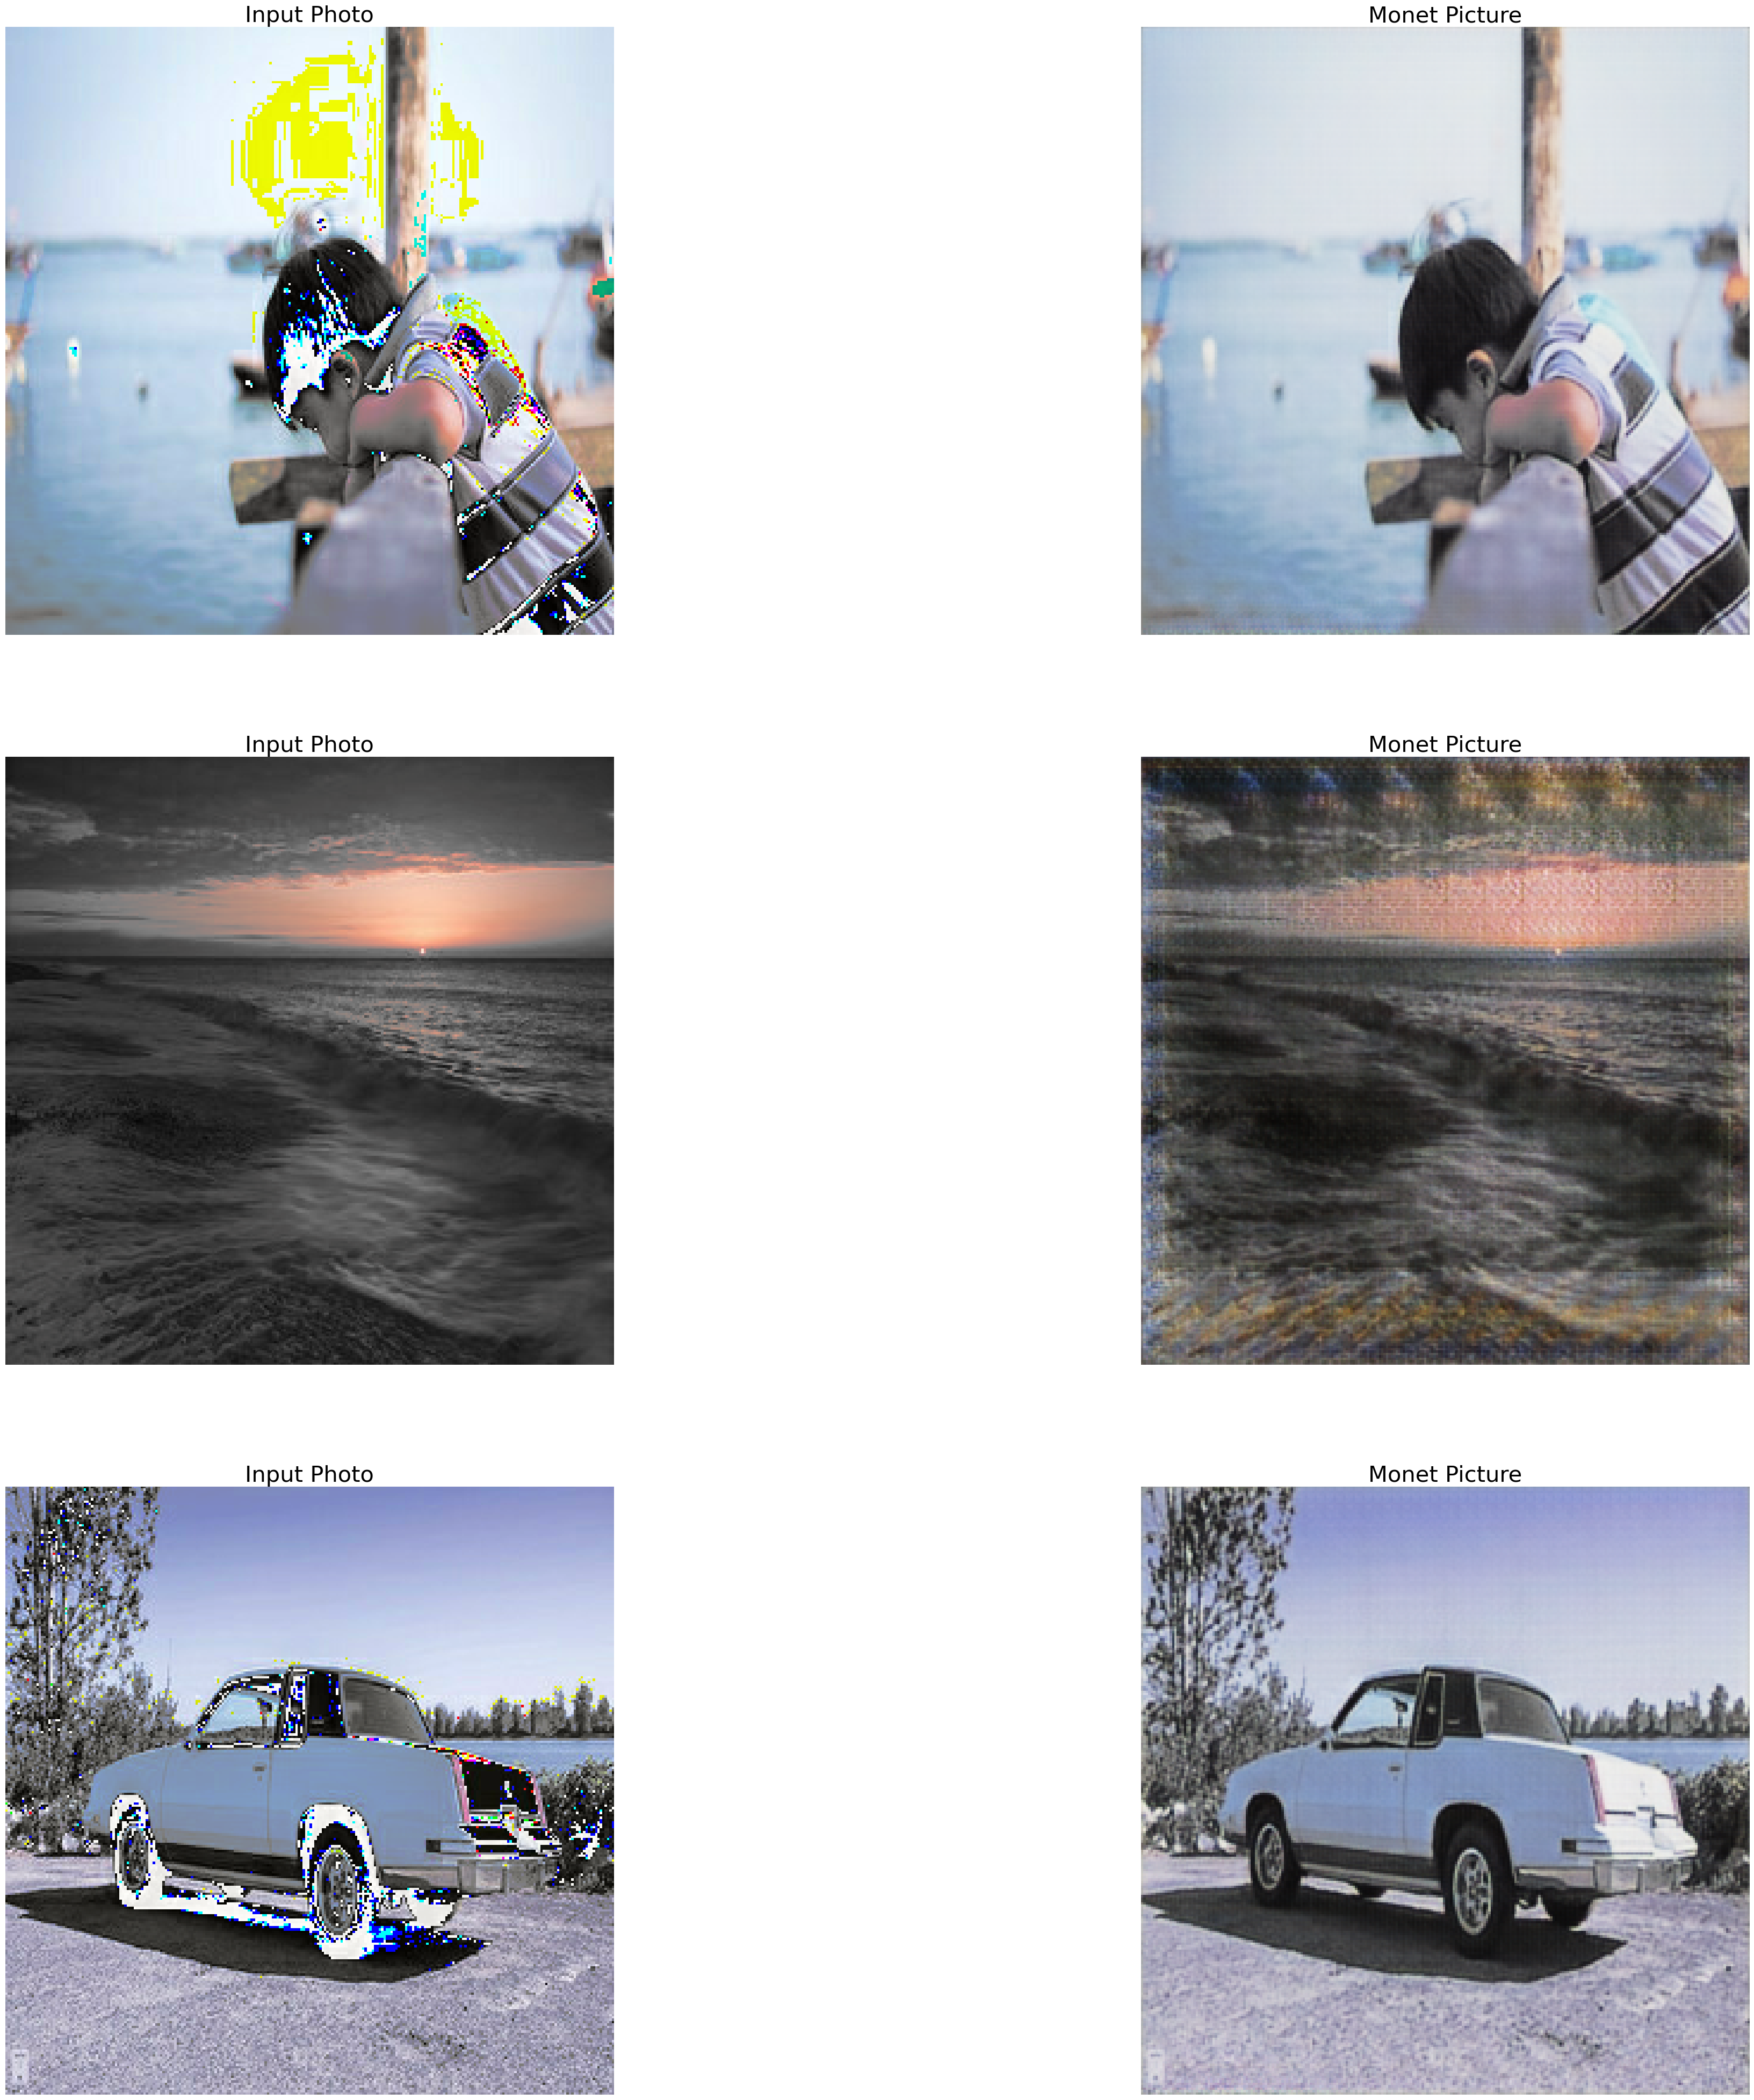

In [20]:
BUFFER_SIZE = len(list(photo_ds.as_numpy_iterator()))
photo_ds_shuffled = photo_ds.shuffle(BUFFER_SIZE)

_, ax = plt.subplots(3, 2, figsize=(50, 50))
for i, img in enumerate(photo_ds_shuffled.take(3)):
    prediction = monetGenerator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo", fontsize=30)
    ax[i, 1].set_title("Monet Picture", fontsize=30)
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
folder_name = "generated"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [ ]:
i = 1
for img in photo_ds:
    prediction = monetGenerator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    
    file_name = str(i) + ".jpg"
    file_path = os.path.join(folder_name, file_name)
    im.save(file_path)
    i += 1

In [ ]:
cyclegan_fid = calculate_fid(real_monet, cycled_monet)

In [ ]:
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(256, 256, 3))

In [29]:
pip install requests beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [57]:
# Example usage
url = 'https://www.monetpaintings.org/paintings/101-200/'
download_folder = 'Monet extra files - wikiart'


In [50]:
import os
import requests
from bs4 import BeautifulSoup
from PIL import Image

# Function to download an image from a given URL
def download_image(url):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    return response

# Function to get the full-sized image URL
def get_full_size_image_url(img):
    srcset = img.get('srcset') or img.get('data-srcset')
    if srcset:
        srcset_urls = srcset.split(',')
        return srcset_urls[-1].strip().split(' ')[0]

    data_full_src = img.get('data-full-src') or img.get('data-large-src') or img.get('data-original')
    if data_full_src:
        return data_full_src

    return img.get('src') or img.get('data-src')

# Function to resize the image
def resize_image(image_data, size):
    img = Image.open(image_data)
    return img

# Main function to scrape and download images from a webpage
def scrape_images(url, download_folder):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Create download folder if it doesn't exist
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    # Find all image tags in the webpage
    img_tags = soup.find_all('img')

    # Iterate through image tags and download the images
    for idx, img in enumerate(img_tags):
        img_url = get_full_size_image_url(img)
        if img_url:
            if img_url.startswith('//'):
                img_url = 'http:' + img_url

            if not img_url.startswith('http'):
                continue

            print(f'Downloading image {idx} from {img_url}')
            try:
                response = download_image(img_url)
                resized_img = resize_image(response.raw, (256, 256))
                save_path = os.path.join(download_folder, f'image_{idx}.jpg')
                resized_img.save(save_path)
            except (requests.exceptions.RequestException, IOError) as e:
                print(f'Failed to download and resize {img_url}: {e}')

scrape_images(url, download_folder)

Failed to download and resize http://www.tqlkg.com/image-7925066-12853712: cannot write mode P as JPEG
Failed to download and resize http://pixel.quantserve.com/pixel/p-31iz6hfFutd16.gif?labels=Domain.monetpaintings_org,DomainId.261855: cannot write mode P as JPEG


In [43]:
pip install selenium


Note: you may need to restart the kernel to use updated packages.


In [ ]:
cd stylegan2-ada

In [ ]:
import os
import sys
import argparse
import train_module
import generate

In [ ]:
def train_stylegan(dataset_path, outdir='./results', snap=10, kimg=5000, mirror=True):
    sys.argv = ['train.py', '--data=' + dataset_path, '--outdir=' + outdir, '--snap=' + str(snap), '--kimg=' + str(kimg)]
    if mirror:
        sys.argv.append('--mirror=true')
    train.main()

def generate_images(trained_model_path, outdir='output_images', trunc=0.7, seeds='0-100'):
    sys.argv = ['generate.py', '--network=' + trained_model_path, '--outdir=' + outdir, '--trunc=' + str(trunc), '--seeds=' + seeds]
    generate.main()

if __name__ == '__main__':
    # Prepare your dataset
    os.system('python dataset_tool.py create_from_images ./datasets/your_dataset_name path/to/your/image/folder')

    # Train the model
    train_stylegan('./datasets/your_dataset_name', outdir='./results', snap=10, kimg=5000, mirror=True)

    # Generate images
    trained_model_path = 'path/to/your/trained/pkl'
    generate_images(trained_model_path, outdir='output_images', trunc=0.7, seeds='0-100')